In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Model equations
$$ \begin{array}
   \dot{x}_{1} &=& y_{1}-f_{1}(x_{1},x_{2})-z+I_{1}\\
   \dot{y}_{1} &=& y_{0}-5x_{1}^{2}-y_{1} \\
   \dot{z} &=& \frac{1}{\tau_{0}}(x_{1}-z)\\
   \dot{x}_{2} &=& -y_{2}+x_{2}-x_{2}^{3}+I_{2}+0.002g(x_{1})-0.3(z-3.5)\\
   \dot{y}_{2} &=& \frac{1}{\tau_{2}}(-y_{2}+f_{2}(x_{2}))
   \end{array}
$$

with:
$$ g(x_{1})=\intop_{t_{0}}^{t}e^{-\gamma(t-\tau)}x_{1}(\tau)d\tau $$
$$ f_{1}(x_{1},x_{2})=
                        \begin{cases}
                        x_{1}^{3}-3x_{1}^{2} & \textrm{if}\,\,x_{1}<0\\
                        (x_{2}-0.6(z-4)^{2})x_{1} & \textrm{if}\,\,x_{1}\geq0
                        \end{cases}
$$
$$f_{2}(x_{1},x_{2})=
                        \begin{cases}
                        0 & \textrm{if}\,\,x_{2}<-0.25\\
                        6(x_{2}+0.25)x_{1} & \textrm{if}\,\,x_{2}\geq-0.25
                        \end{cases}
$$

Stimulation occurs on $I_1$ and $I_2$ simultaneously

## Simulation notes
For all the simulations, we follow this convention:
1 time unit = 10 ms


In [8]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


lx0 = np.arange(-1.9, -2.1, -0.01)
llq = []
for x0 in lx0:
    print(x0)

    # Parameters
    parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
                  'tau':10, 'a2':6, 'c2':0.3, 'm':0,
                  'x0':x0, 'r':0.00005, 's':4,
                  'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0} # 0.00035

    # Find initial conditions by root solving
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)

    # sim parameters
    dt = 0.001
    t_sim_init = 1000
    n_samples_init = int(t_sim_init/dt)
    t_sim = 10000
    n_samples = int(t_sim/dt)
    upsamp = 10
    t = np.linspace(0, t_sim, t_sim * upsamp)

    for it in range(n_samples_init):
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

    lq = []
    for it in range(n_samples):
        # if it%10000==0:
        #     print(it)
        tc = it*dt

        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)
        
        if it%int(1/(upsamp*dt))==0:
            lq.append(q.copy())
    llq.append(lq)

llq = np.array(llq)

-1.9
-1.91
-1.92
-1.93
-1.94
-1.95
-1.96
-1.97
-1.98
-1.99
-2.0
-2.01
-2.02
-2.0300000000000002
-2.04
-2.05
-2.06
-2.0700000000000003
-2.08
-2.09
-2.1


### Time series

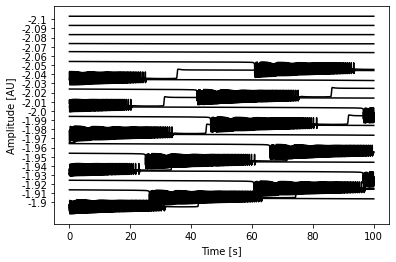

In [11]:
ts = -llq[:, :, 0] + llq[:, :, 3]
plt.figure()
for ix0 in range(len(lx0)):
    plt.plot(t/100, ts[ix0] + 2*ix0, 'k')
#plt.xlim([0, 1])
plt.yticks(2*np.arange(len(lx0)), np.round(lx0, 2))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [AU]')
plt.savefig('figures/stability_without_stim.svg')